In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import os
from google.colab import drive
import seaborn as sns
import pandas as pd
from skimage.filters import sobel
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from skimage.feature import local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import metrics
from pathlib import Path
import xgboost as xgb
import lightgbm as lgb
from PIL import Image, ImageOps
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, auc, roc_curve, roc_auc_score, recall_score, confusion_matrix


In [2]:
# This will prompt for authorization.
drive.mount('/content/drive')
# Define the root data directory
DATA_DIR = "/content/drive/MyDrive/dataset"

Mounted at /content/drive


##LBP

In [3]:
def compute_lbp(arr):
  # LBP function params
  radius = 3
  n_points = 8 * radius
  n_bins = n_points + 2
  lbp = local_binary_pattern(arr,n_points,radius,'uniform')
  lbp = lbp.ravel()
  #feature_len = int(lbp.max() + 1)
  feature = np.zeros(n_bins)
  for i in lbp:
    feature[int(i)] += 1 # Feature
  feature /= np.linalg.norm(feature, ord=1) # Normalizing feature
  return feature

lbp train data

In [4]:
SIZE = 224
train_images_lbp = []
train_labels_lbp = [] 
#for directory_path in glob.glob("cell_images/train/*"):
for directory_path in glob.glob("/content/drive/MyDrive/dataset/sub_set/train/*"):
    label_lbp_train = directory_path.split("/")[-1]
    print(label_lbp_train)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        #print(img_path)
        img1 = cv2.imread(img_path,0) #Reading color images
        img1 = cv2.resize(img1, (SIZE, SIZE)) #Resize images
        arr = np.array(img1) # convert the image to numpy array
        feature_train_lbp = compute_lbp(arr)
        train_images_lbp.append(feature_train_lbp)
        train_labels_lbp.append(label_lbp_train)

train_images_lbp =np.array(train_images_lbp)
trait_labels_lbp =np.array(train_labels_lbp)


nevus
others


lbp val data

In [12]:

test_images_lbp = []
test_labels_lbp = [] 
#for directory_path in glob.glob("cell_images/train/*"):
for directory_path in glob.glob("/content/drive/MyDrive/dataset/sub_set/val/*"):
    label_lbp_test = directory_path.split("/")[-1]
    print(label_lbp_test)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        #print(img_path)
        img2 = cv2.imread(img_path,0) #Reading color images
        img2 = cv2.resize(img2, (SIZE, SIZE)) #Resize images
        arr = np.array(img2) # convert the image to numpy array
        feature_test = compute_lbp(arr)
        test_images_lbp.append(feature_test)
        test_labels_lbp.append(label_lbp_test)

test_images_lbp =np.array(test_images_lbp)
test_labels_lbp =np.array(test_labels_lbp)

nevus
others


#COLOR HIST

color_hist train

In [6]:
def hist_features(img):
  hist_blue = cv2.calcHist([img],[0],None,[256],[0,256]) #blue
  hist_green = cv2.calcHist([img],[1],None,[256],[0,256])
  hist_red = cv2.calcHist([img],[2],None,[256],[0,256])
  hist=np.hstack([hist_green,hist_red,hist_blue])
  return hist.flatten()

In [ ]:
#Resize images to
SIZE = 224

#Capture images and labels into arrays.
#Start by creating empty lists.
train_hist = []
train_label_hist = [] 
for directory_path in glob.glob("/content/drive/MyDrive/dataset/sub_set/train/*"):
    labelhist = directory_path.split("\\")[-1]
    print(labelhist)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print(img_path)
        img3 = cv2.imread(img_path,cv2.COLOR_BGR2RGB) #Reading color images
        img3 = cv2.resize(img3, (SIZE, SIZE)) #Resize images
        img3=hist_features(img3) #call the function
        train_hist.append(img3)
        train_label_hist.append(labelhist)

train_hist = np.array(train_hist)
train_label_hist= np.array(train_label_hist)

color hist test

In [ ]:

#Resize images to
SIZE = 224

#Capture images and labels into arrays.
#Start by creating empty lists.
test_hist = []
test_label_hist = [] 
for directory_path in glob.glob("/content/drive/MyDrive/dataset/sub_set/val/*"):
    labelhist_test = directory_path.split("\\")[-1]
    print(labelhist_test)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print(img_path)
        img4 = cv2.imread(img_path,cv2.COLOR_BGR2RGB) #Reading color images
        img4 = cv2.resize(img4, (SIZE, SIZE)) #Resize images
        img4=hist_features(img4)
        test_hist.append(img4)
        test_label_hist.append(labelhist_test)

test_hist = np.array(test_hist)
test_label_hist= np.array(test_label_hist)

concat lbp and color 


In [8]:
train_images_lbp.shape

(7203, 26)

In [13]:
train_feature_lhist=np.concatenate((train_images_lbp,train_hist),axis=1)
test_feature_lhist=np.concatenate((test_images_lbp,test_hist),axis=1)


In [34]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_label_hist)
test_labels_encoded = le.transform(test_label_hist)
le.fit(train_label_hist)
train_labels_encoded = le.transform(train_label_hist)

#GLCM

glcm train data

In [14]:
def feature_extractor(dataset):
  image_dataset  = pd.DataFrame()
  distance = [11, 21]
  angle = [0, np.pi/4, np.pi/2, 3*np.pi/4]
  for image in range(dataset.shape[0]):
    img = dataset[image]
    df = pd.DataFrame()
    count = 1
    for dist in distance:
      for ang in angle:
        GLCM = greycomatrix(img, [dist], [ang])      
        GLCM_Energy = greycoprops(GLCM, 'energy')[0]
        df[f'Energy{count}'] = GLCM_Energy
        GLCM_corr = greycoprops(GLCM, 'correlation')[0]
        df[f'Corr{count}'] = GLCM_corr             
        GLCM_hom = greycoprops(GLCM, 'homogeneity')[0]
        df[f'Homogen{count}'] = GLCM_hom       
        GLCM_contr = greycoprops(GLCM, 'contrast')[0]
        df[f'Contrast{count}'] = GLCM_contr
        count = count + 1
    image_dataset = image_dataset.append(df)    
  return image_dataset

In [ ]:
#Resize images to
SIZE = 224

#Capture images and labels into arrays.
#Start by creating empty lists.
train_image_glcm = []
train_label_glcm = [] 
for directory_path in glob.glob("/content/drive/MyDrive/dataset/sub_set/train/*"):
    label_glcm = directory_path.split("\\")[-1]
    #print(label_glcm)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print(img_path)
        img5= cv2.imread(img_path,0)
        #img5 = cv2.imread(img_path,cv2.COLOR_BGR2RGB) #Reading color images
        img5 = cv2.resize(img5, (SIZE, SIZE)) #Resize images
        train_image_glcm.append(img5)
        train_label_glcm.append(label_glcm)


train_label_glcm= np.array(train_label_glcm) 
train_image_glcm = np.array(train_image_glcm)


In [16]:
train_image_glcm.shape

(7203, 224, 224)

In [17]:
#x_train=train_image_glcm

In [18]:
train_feature_glcm = feature_extractor(train_image_glcm)

In [19]:
train_feature_glcm.shape

(7203, 32)

test data for glcm

In [ ]:
#Resize images to
SIZE = 224

#Capture images and labels into arrays.
#Start by creating empty lists.
test_image_glcm = []
test_label_glcm = [] 
for directory_path in glob.glob("/content/drive/MyDrive/dataset/sub_set/val/*"):
    label_glcm_test = directory_path.split("\\")[-1]
    #print(label_glcm)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print(img_path)
        img6= cv2.imread(img_path,0)
        #img5 = cv2.imread(img_path,cv2.COLOR_BGR2RGB) #Reading color images
        img6 = cv2.resize(img6, (SIZE, SIZE)) #Resize images
        test_image_glcm.append(img6)
        test_label_glcm.append(label_glcm_test)


test_label_glcm= np.array(test_label_glcm) 
test_image_glcm = np.array(test_image_glcm)

In [21]:
test_feature_glcm = feature_extractor(test_image_glcm)

Concat glcm, rgb hist and lbp

In [22]:
train_feature_ghl=np.concatenate((train_images_lbp,train_hist,train_feature_glcm,train_images_lbp),axis=1)
test_feature_ghl=np.concatenate((test_images_lbp,test_hist,test_feature_glcm,test_images_lbp),axis=1)

#HSV Hist

In [23]:
def hsv_hist_features(img):
    h, s, v = img[:,:,0], img[:,:,1], img[:,:,2]
    hist_h = cv2.calcHist([h],[0],None,[256],[0,256])
    #hist_s = cv2.calcHist([s],[0],None,[256],[0,256])
    #hist_v = cv2.calcHist([v],[0],None,[256],[0,256])
    hist=np.hstack([hist_h])
    return hist.flatten()

In [24]:
a=hsv_hist_features(train_image_glcm)

In [ ]:
#Resize images to
SIZE = 224

#Capture images and labels into arrays.
#Start by creating empty lists.
train_hsv = []
train_label_hsv = [] 
for directory_path in glob.glob("/content/drive/MyDrive/dataset/sub_set/train/*"):
    labelhsv = directory_path.split("\\")[-1]
    print(labelhsv)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print(img_path)
        img7 = cv2.imread(img_path,cv2.COLOR_BGR2HSV) #Reading color images
        img7 = cv2.resize(img7, (SIZE, SIZE)) #Resize images
        img7=hsv_hist_features(img7) #call the function
        train_hsv.append(img7)
        train_label_hsv.append(labelhsv)

train_hsv = np.array(train_hsv)
#train_label_hsv= np.array(train_label_hsv)

In [ ]:
#Resize images to
SIZE = 224

#Capture images and labels into arrays.
#Start by creating empty lists.
test_hsv = []
test_label_hsv = [] 

for directory_path in glob.glob("/content/drive/MyDrive/dataset/sub_set/val/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print(img_path)
        img8 = cv2.imread(img_path,cv2.COLOR_BGR2HSV) #Reading color images
        img8 = cv2.resize(img8, (SIZE, SIZE)) #Resize images
        img8=hsv_hist_features(img8) #call the function
        test_hsv.append(img8)
        test_label_hsv.append(label)

test_hsv = np.array(test_hsv)


Importing test_set

In [ ]:
'''test_images = []
test_ID_2 = []
counter = 1
#hu_features_test = []
test_array=[]
#for directory_path in glob.glob("cell_images/test/*"): 
for directory_path in glob.glob("/content/sample_check/*"):
   test_label = directory_path.split("/")[-1]
   print(test_label)
   test_ID_2.append(test_label)
   test_array.append(counter)
   counter = counter+1
   for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, 0)
        #img = cv2.resize(img, (SIZE, SIZE))
        test_images.append(img)
        #test_ID_1.append(test_label)
        
test_images = np.array(test_images)
#test_ID = np.array(test_ID)
test_array = np.array(test_array)

#combine glcm. lbp, RGB, HSV

In [30]:
train_feature_all=np.concatenate((train_hist,train_feature_glcm,train_images_lbp,train_hsv),axis=1)
test_feature_all=np.concatenate((test_hist,test_feature_glcm,test_images_lbp,test_hsv),axis=1)

In [31]:
# x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

#SVM

In [32]:
pipe1 = Pipeline([
                 ("scale", StandardScaler()),
                 ("classifier", SVC(class_weight='balanced', probability=True, kernel= 'rbf', gamma=0.01, C=100)) #radial basis function kernel
                 ])

In [35]:
pipe1.fit(train_feature_all,train_labels_encoded)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier',
                 SVC(C=100, class_weight='balanced', gamma=0.01,
                     probability=True))])

In [36]:
# Test set evaluation
prediction_svm = pipe1.predict(test_feature_all)
# Visualization
cmat = metrics.confusion_matrix(prediction_svm,test_labels_encoded)
#s = sns.heatmap(cmat,annot=True,xticklabels=label, yticklabels=label)
#s.set(xlabel='Predicted', ylabel='Actual')
acc_svm = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc_svm*100))

Accuracy: 73.29%


#Random forest

In [90]:
pipe2 = Pipeline([
                 ("scale", StandardScaler()),
                 ("classifier", RandomForestClassifier(n_estimators = 800, max_depth=60,random_state = 42))
                 ])

In [91]:
pipe2.fit(train_feature_all,train_labels_encoded)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=60, n_estimators=800,
                                        random_state=42))])

In [95]:
train_feature_all.shape

(7203, 1082)

In [93]:
# Test set evaluation
prediction_rf = pipe2.predict(test_feature_all)
# Visualization
cmat_r = metrics.confusion_matrix(prediction_rf,test_labels_encoded)
#s = sns.heatmap(cmat,annot=True,xticklabels=label, yticklabels=label)
#s.set(xlabel='Predicted', ylabel='Actual')
acc_r = cmat_r.trace() / cmat_r.sum()
print('Accuracy: {0:5.2f}%'.format(acc_r*100))

Accuracy: 80.30%


#KNN

In [40]:
pipe3 = Pipeline([
                 ("scale",StandardScaler()),
                 ("classifier", KNeighborsClassifier(n_neighbors=10))
                 ])

In [41]:
pipe3.fit(train_feature_all,train_labels_encoded)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier', KNeighborsClassifier(n_neighbors=10))])

In [42]:
# Test set evaluation
prediction_knn = pipe3.predict(test_feature_all)
# Visualization
cmat_knn = metrics.confusion_matrix(prediction_knn,test_labels_encoded)
#s = sns.heatmap(cmat,annot=True,xticklabels=label, yticklabels=label)
#s.set(xlabel='Predicted', ylabel='Actual')
acc_knn = cmat_knn.trace() / cmat_knn.sum()
print('Accuracy: {0:5.2f}%'.format(acc_knn*100))

Accuracy: 75.38%


#XGB

In [43]:
mod1 = xgb.XGBClassifier(booster='dart',learning_rate=0.2)
train_arr = np.array(train_feature_all)
test_arr = np.array(test_feature_all)
mod1.fit(train_arr, train_labels_encoded)

XGBClassifier(booster='dart', learning_rate=0.2)

In [44]:
prediction_xgb = mod1.predict(test_arr)
print("Accuracy = ", accuracy_score(test_labels_encoded, prediction_xgb)*100)
#print('Accuracy: {0:5.2f}%'.format(acc*100))

Accuracy =  79.17093142272262


#LightGBM

In [45]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_feature_all)
test_scaled = scaler.transform(test_feature_all)
d_train = lgb.Dataset(train_scaled, label=train_labels_encoded)

In [46]:
lgbm_params = {'learning_rate':0.05, 'boosting_type':'gbdt', #Sometimes dart gives better accuracy. gbdt means gradient boosting.
              'objective':'binary',
              'metric':['auc', 'binary_logloss'],
              'num_leaves':100, # optimizing this avoids overfitting. 50 to 100
              'max_depth':10} #10 may be appropriate

In [47]:
clf = lgb.train(lgbm_params, d_train, 70) #50 iterations. Increase iterations for small learning rates. eg if learning grate = 0.005, we may need 500 iterations.
prediction_lgb=clf.predict(test_scaled)
#convert the probabilities into binary values 0/1 for classification
for i in range(0, test_scaled.shape[0]):
    if prediction_lgb[i]>=.5: # setting threshold to 0.5
       prediction_lgb[i]=1
    else:  
       prediction_lgb[i]=0

In [48]:
#Print accuracy
print ("Accuracy with LGBM = ", accuracy_score(test_labels_encoded, prediction_lgb)*100)


Accuracy with LGBM =  78.96622313203684


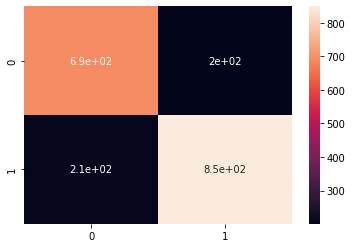

In [49]:
#Confusion matrix
cm_lgbm = confusion_matrix(test_labels_encoded, prediction_lgb)
sns.heatmap(cm_lgbm, annot=True)

#Adaboost

In [50]:
clf_adb = AdaBoostClassifier(n_estimators=200, random_state=0)
clf_adb.fit(train_feature_all,train_labels_encoded)

AdaBoostClassifier(n_estimators=200, random_state=0)

In [51]:
# Test set evaluation
prediction_adb = clf_adb.predict(test_feature_all)
# Visualization
cmat = confusion_matrix(prediction_adb,test_labels_encoded)
#s = sns.heatmap(cmat,annot=True,xticklabels=label, yticklabels=label)
#s.set(xlabel='Predicted', ylabel='Actual')
acc_adb = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc_adb*100))

Accuracy: 76.66%


In [52]:
prediction_prob = clf_adb.predict_proba(test_feature_all)
print("Area under curve (AUC): ", roc_auc_score(test_labels_encoded, prediction_prob[:,1]))

Area under curve (AUC):  0.8363175969740612


#random try

In [53]:
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression()

# Support Vector Machines
from sklearn.svm import LinearSVC
models['Support Vector Machines'] = LinearSVC()

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['Decision Trees'] = DecisionTreeClassifier()

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier()

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
models['Naive Bayes'] = GaussianNB()

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
models['K-Nearest Neighbor'] = KNeighborsClassifier()

In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy, precision, recall = {}, {}, {}

for key in models.keys():
    
    # Fit the classifier
    models[key].fit(train_feature_all, train_labels_encoded)
    
    # Make predictions
    predictions = models[key].predict(test_feature_all)
    
    # Calculate metrics
    accuracy[key] = accuracy_score(predictions, test_labels_encoded)
    precision[key] = precision_score(predictions,test_labels_encoded)
    recall[key] = recall_score(predictions, test_labels_encoded)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [55]:
import pandas as pd

df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()

df_model

,Accuracy,Precision,Recall
Logistic Regression,0.685261,0.729934,0.701452
Support Vector Machines,0.650972,0.906516,0.622165
Decision Trees,0.684749,0.692162,0.716520
Random Forest,0.801945,0.808310,0.823077
Naive Bayes,0.698055,0.754485,0.707706
K-Nearest Neighbor,0.715967,0.792257,0.714651


#Doing the final pipeline

loading final TEST data, LBP feature

In [56]:
'''est_image_glcm = []

test_image_ID= []

#hu_features_test = []

for directory_path in sorted(glob.glob("/content/drive/MyDrive/Multiclass/multi_test/*")):

    test_label = directory_path.split("/")[-1]

    print(test_label)

    #test_image_ID.append(test_label)

for directory_path in sorted(glob.glob("/content/drive/MyDrive/Multiclass/multi_test")):

    for img_path in sorted(glob.glob(os.path.join(directory_path, "*.jpg"))):

        #print(img_path)

        img1 = cv2.imread(img_path,0)

        img1 = cv2.resize(img1, (SIZE, SIZE))

        test_image_glcm.append(img1)

        

test_image_glcm = np.array(test_image_glcm)

In [ ]:
test_image = []
test_image_ID= []
#t_lbp=[]
#hu_features_test = []
for directory_path in sorted (glob.glob("/content/drive/MyDrive/testX/*")):
    test_label = directory_path.split("/")[-1]
    print(test_label)
    test_image_ID.append(test_label)
for directory_path in sorted (glob.glob("/content/drive/MyDrive/testX")):
    for img_path in sorted (glob.glob(os.path.join(directory_path, "*.jpg"))):
        img1 = cv2.imread(img_path, 0)
        img1 = cv2.resize(img1, (SIZE, SIZE))
        #arr1 = np.array(img1) # convert the image to numpy array
        #feature_test = compute_lbp(arr1)
        test_image.append(img1)
        #t_lbp.append(feature_test)
         #call the function
        
test_image = np.array(test_image)
#t_lbp=np.array(t_lbp)


#LBP

In [65]:
t_lbp=[]

#hu_features_test = []
for directory_path in sorted (glob.glob("/content/drive/MyDrive/testX/*")):
    test_label = directory_path.split("/")[-1]
for directory_path in sorted (glob.glob("/content/drive/MyDrive/testX/")):
    for img_path in sorted (glob.glob(os.path.join(directory_path, "*.jpg"))):
      img11 = cv2.imread(img_path,0) #Reading color images
      img11 = cv2.resize(img11, (SIZE, SIZE)) #Resize images
      arr1 = np.array(img11) # convert the image to numpy array
      feature_train_lbp = compute_lbp(arr1)
      t_lbp.append(feature_train_lbp)
      
       
       
       
         #call the function
        
t_lbp=np.array(t_lbp)


In [69]:
len(test_image_ID)

6340

In [60]:
t_lbp.shape

(6340, 26)

In [ ]:
test_image_ID

GLCM for test

In [68]:
t_image_glcm=feature_extractor(test_image)

In [70]:
t_image_glcm.shape

(6340, 32)

Color hist feature 

In [ ]:
t_hist=[]

#hu_features_test = []
for directory_path in sorted (glob.glob("/content/drive/MyDrive/testX/*")):
    test_label = directory_path.split("/")[-1]
    print(test_label)
    #test_image_ID.append(test_label)#dont appened 
for directory_path in sorted (glob.glob("/content/drive/MyDrive/testX/")):
    for img_path in sorted (glob.glob(os.path.join(directory_path, "*.jpg"))):
       
        img33 = cv2.imread(img_path,cv2.COLOR_BGR2RGB) #Reading color images
        img33 = cv2.resize(img33, (SIZE, SIZE)) #Resize images
        img33=hist_features(img33) #call the function
        t_hist.append(img33)
        
       
         #call the function
        
t_hist=np.array(t_hist)


combining GLCM< LBP and RGB hist

In [71]:
train_feature_final=np.concatenate((train_hist,train_feature_glcm,train_images_lbp),axis=1)
test_feature_final=np.concatenate((t_hist,t_image_glcm,t_lbp),axis=1)

In [94]:
prediction_rf = pipe2.predict(test_feature_final)

ValueError: ignored

lightGBM

In [ ]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_feature_final)
test_scaled = scaler.transform(test_feature_final)
d_train = lgb.Dataset(train_scaled, label=train_labels_encoded)

In [ ]:
lgbm_params = {'learning_rate':0.05, 'boosting_type':'gbdt', #Sometimes dart gives better accuracy. gbdt means gradient boosting.
              'objective':'binary',
              'metric':['auc', 'binary_logloss'],
              'num_leaves':100, # optimizing this avoids overfitting. 50 to 100
              'max_depth':10} #10 may be appropriate

In [ ]:
clf = lgb.train(lgbm_params, d_train, 70) #50 iterations. Increase iterations for small learning rates. eg if learning grate = 0.005, we may need 500 iterations.
prediction_lgb=clf.predict(test_scaled)
#convert the probabilities into binary values 0/1 for classification
for i in range(0, test_scaled.shape[0]):
    if prediction_lgb[i]>=.5: # setting threshold to 0.5
       prediction_lgb[i]=1
    else:  
       prediction_lgb[i]=0

In [ ]:
len(test_image_ID)

In [ ]:
test_image_ID

In [ ]:
prediction_lgb.shape

In [ ]:
res = pd.DataFrame(prediction_lgb)
res.index = test_image_ID # its important for comparison
res.columns = ["prediction"]
res.to_csv("prediction_binary.csv")
